# Understanding the PyBaMM pipeline and performance profile of the Simulation class

This notebook discusses the main steps that PyBaMM performs to go from an initial model to a final solution, and how you can use this information to optimise the performance of your simulations. We will also discuss the `pybamm.Simulation` class, which is a convenience class that wraps up the entire pipeline into a single class, and how you can use this class most efficiently to run your simulations, taking into account the performance characteristics of the different steps of the pipeline and the caching behaviour of the `pybamm.Simulation` class.


In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import numpy as np

import pybamm

Note: you may need to restart the kernel to use updated packages.



## The PyBaMM Pipeline

The PyBaMM pipeline is a series of steps that are taken to go from a model to a final solution. 
At the start of the pipeline, a pybamm model consists of a set of equations make up of symbols arranged in an [expression tree](https://docs.pybamm.org/en/stable/source/examples/notebooks/expression_tree/expression-tree.html). Each symbol could be a parameter (`pybamm.Parameter`), a variable (`pybamm.Variable`), a binary operator (`pybamm.Addition`, `pybamm.Multiplication`, etc.), or a unary operator (`pybamm.Negate`, `pybamm.Gradient`). You can see all the possible symbols in the API docs [here](https://docs.pybamm.org/en/stable/source/api/expression_tree/index.html). The pipeline is a series of steps that first transforms this expression tree into a form that can be solved by a numerical solver, and then solves the equations to get the solution.


The pipeline is as follows:

1. **Parameter replacement** - The first step of the pipeline is performed by the [`pybamm.ParameterValues`](https://docs.pybamm.org/en/stable/source/api/parameters/parameter_values.html#pybamm.ParameterValues) class, which (a) replaces all `pybamm.Parameter` symbols with their corresponding values (e.g. using `pybamm.Scalar`), and (b) replaces all `pybamm.FunctionParameter` symbols with either a `pybamm.Scalar`, `pybamm.Interpolant`, or `pybamm.Function` object. 
2. **Discretisation** - The next step is to discretise the model equations. This is done by the [`pybamm.Discretisation`](https://docs.pybamm.org/en/stable/source/api/spatial_methods/discretisation.html) class, which replaces all the symbols representing spatial derivatives (e.g. `pybamm.Gradient`) with a matrix that can be used to solve the equations numerically.
3. **Solver setup** - The next step is to set up the numerical solver. This is done by the [`pybamm.BaseSolver`](https://docs.pybamm.org/en/stable/source/api/solvers/base_solver.html#pybamm.BaseSolver) class, which transforms the expression trees into a form that can be evaluated by the numerical solver. PyBaMM has a few different forms that can be used, but generally, this means that each expression tree is transformed into a CasADi function that can be evaluated at a given time and state.
4. **Solver solve** - The next step is to solve the equations. This is done by the numerical solver, which in most cases is one of the solvers provided by the [Sundials](https://sundials.readthedocs.io/en/latest/#) suite of solvers. The solver takes the CasADi functions generated in the previous step and uses them to solve the equations numerically.
5. **Post-processing** - The output of the previous step is the solution to the equations at a set of time points. The final step is to post-process this solution to get the variables of interest. This is done by the [`pybamm.Solution`](https://docs.pybamm.org/en/stable/source/api/solvers/solution.html) and [`pybamm.ParameterValues`](https://docs.pybamm.org/en/stable/source/api/parameters/parameter_values.html#pybamm.ParameterValues) classes, which take the solution and the parameter values and return the variables of interest interpolated at the desired time points.

For every simulation you run with PyBaMM, these steps are always performed in order to generate each solution, even if they are hidden from you by various convenience classes like [`pybamm.Simulation`](https://docs.pybamm.org/en/stable/source/api/simulation.html) . Understanding the pipeline is important because it can help you identify where the performance bottlenecks are in your simulations, and how you can optimise them to get the best performance.

Below is a simple example that demonstrates the different parts of the pipeline, using the DFN model. While you probably have seen something similar to this script before, the one difference is that we have split the solver setup (step 3) and solve (step 4) parts of the pipeline into two separate steps. Often these are combined into the first call to the solver, but we have split them here to make it clear that they are separate steps.

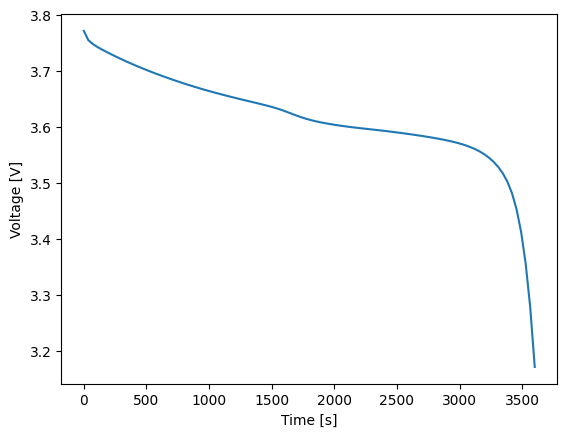

In [2]:
# load model
model = pybamm.lithium_ion.DFN()

# Step 1: Parameter replacement
parameter_values = model.default_parameter_values
parameter_values.process_model(model)
geometry = model.default_geometry
parameter_values.process_geometry(geometry)

# Step 2: Discretisation
mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

# Step 3: Solver setup
#    The `set_up` method is normally called by the `solve` method if not called explicitly.
#    We also need to update `_model_set_up` to include the initial conditions or the solver
#    will call `set_up` again during `solve`.
solver = pybamm.IDAKLUSolver()
solver.set_up(model)
solver._model_set_up.update(
    {model: {"initial conditions": model.concatenated_initial_conditions}}
)

# Step 4: Solver solve
solution = solver.solve(model, [0, 3600])

# Step 5: Post-processing
t_evals = np.linspace(0, 3600, 100)
voltage = solution["Terminal voltage [V]"](t_evals)

# Plot the results
import matplotlib.pyplot as plt

plt.plot(t_evals, voltage)
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.show()

Now we'll instrument this script to time each part of the pipeline, using the high-resolution timer provided by the `time` module in Python. This will allow us to see how long each part of the pipeline takes, and where the performance bottlenecks are.

In [3]:
import time

# load model
model = pybamm.lithium_ion.DFN()

# Step 1: Parameter replacement
total_start = time.perf_counter()
start = time.perf_counter()
parameter_values = model.default_parameter_values
parameter_values.process_model(model)
geometry = model.default_geometry
parameter_values.process_geometry(geometry)
end = time.perf_counter()
print(f"Parameter replacement took {end - start:.3f} seconds")

# Step 2: Discretisation
start = time.perf_counter()
mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)
end = time.perf_counter()
print(f"Discretisation took {end - start:.3f} seconds")

# Step 3: Solver setup
start = time.perf_counter()
solver = pybamm.IDAKLUSolver()
solver.set_up(model)
solver._model_set_up.update(
    {model: {"initial conditions": model.concatenated_initial_conditions}}
)
end = time.perf_counter()
print(f"Solver setup took {end - start:.3f} seconds")

# Step 4: Solver solve
start = time.perf_counter()
solution = solver.solve(model, [0, 3600])
end = time.perf_counter()
print(f"Solver solve took {end - start:.3f} seconds")

# Step 5: Post-processing
start = time.perf_counter()
t_evals = np.linspace(0, 3600, 100)
voltage = solution["Terminal voltage [V]"](t_evals)
end = time.perf_counter()
print(f"Post-processing took {end - start:.3f} seconds")
total_end = time.perf_counter()
print(f"Total time taken: {total_end - total_start:.3f} seconds")

Parameter replacement took 0.073 seconds
Discretisation took 0.238 seconds
Solver setup took 0.076 seconds
Solver solve took 0.028 seconds
Post-processing took 0.002 seconds
Total time taken: 0.418 seconds


From this output, we can see that the actual time taken to solve the equations is only a small percentage (less than 10%) of the total time taken to run the simulation. In fact, the most time-consuming step is the discretisation, which takes roughly 50% of the total time to discretise the spatial derivatives of the model. Even when this has all been done, the solver setup takes more than double the time of the actual solve. All of these numbers emphasises the fact that there is significant overhead in setting up the equations and the solver before the actual solution can be computed. Therefore, if you are looking to optimise the performance of your simulations, you should take care to ensure that you minimise the time spent in the setup steps of the pipeline, particularly if you are running many simulations with the same model and/or discretisation.

Note you can also use the logging features in PyBaMM to automatically print out the time taken for the solver setup and solve time. This can be done by setting the logging level to `INFO` before running the simulation, like so:

In [4]:
pybamm.set_logging_level("INFO")

# load model
model = pybamm.lithium_ion.DFN()

# Step 1: Parameter replacement
parameter_values = model.default_parameter_values
parameter_values.process_model(model)
geometry = model.default_geometry
parameter_values.process_geometry(geometry)

# Step 2: Discretisation
var = pybamm.standard_spatial_vars
mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

# Step 3 & 4: Solver setup
solver = pybamm.IDAKLUSolver()
t_eval = [0, 3600]
solution = solver.solve(model, t_eval)

# Step 5: Post-processing
t_interp = np.linspace(0, 3600, 100)
voltage = solution["Terminal voltage [V]"](t_interp)

pybamm.set_logging_level("WARNING")

2025-01-07 17:32:33.236 - [INFO] base_model._build_model(829): Start building Doyle-Fuller-Newman model
2025-01-07 17:32:33.268 - [INFO] base_battery_model.build_model(1072): Finish building Doyle-Fuller-Newman model
2025-01-07 17:32:33.269 - [INFO] parameter_values.process_model(463): Start setting parameters for Doyle-Fuller-Newman model
2025-01-07 17:32:33.340 - [INFO] parameter_values.process_model(532): Finish setting parameters for Doyle-Fuller-Newman model
2025-01-07 17:32:33.344 - [INFO] discretisation.process_model(142): Start discretising Doyle-Fuller-Newman model
2025-01-07 17:32:33.581 - [INFO] discretisation.process_model(244): Finish discretising Doyle-Fuller-Newman model
2025-01-07 17:32:33.582 - [INFO] base_solver.solve(758): Start solving Doyle-Fuller-Newman model with IDA KLU solver
2025-01-07 17:32:33.584 - [INFO] base_solver.set_up(138): Start solver set-up
2025-01-07 17:32:33.637 - [INFO] base_solver.set_up(280): Finish solver set-up
2025-01-07 17:32:33.689 - [INFO

## The Simulation Class

The `pybamm.Simulation` class is a convenience class that wraps up the entire pipeline into a single class that can be used to setup the model equations and solver and run the simulation in a single call. This class is an easy-to-use wrapper for the PyBaMM pipeline, and provides many useful features for initialising simulations and running experiments. However, it is important to understand that the `pybamm.Simulation` class still performs all the steps of the pipeline, and so the performance characteristics of the `pybamm.Simulation` class are the same as the individual steps of the pipeline.

Lets see how we can use the `pybamm.Simulation` class to run the same simulation as above:

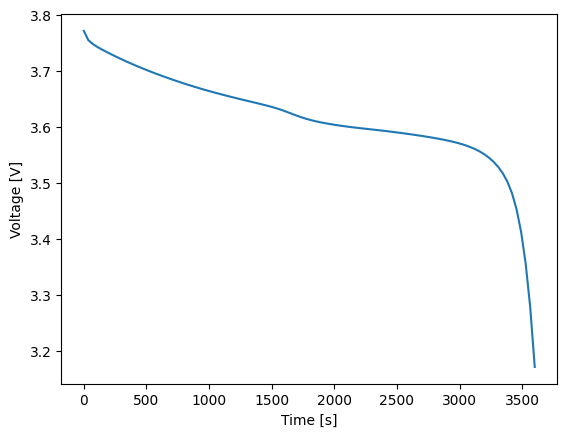

In [5]:
# create simulation
model = pybamm.lithium_ion.DFN()
solver = pybamm.IDAKLUSolver()
sim = pybamm.Simulation(model, solver=solver)

# solve
solution = sim.solve([0, 3600])

# Post-processing
t_evals = np.linspace(0, 3600, 100)
voltage = solution["Terminal voltage [V]"](t_evals)

# Plot the results
import matplotlib.pyplot as plt

plt.plot(t_evals, voltage)
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.show()

Once again we can instrument this script to time the different parts. In this case, the entire pipeline is performed during the `solve` call, but helpfully the `pybamm.Simulation` class will cache the discretisation and solver setup so that they only need to be performed once. So subsequent calls to `solve` will be faster than the first call and will only include the solver solve step (step 4). So we can time the first call to `solve` and then time subsequent calls to `solve` to see the difference.

In [6]:
model = pybamm.lithium_ion.DFN()
solver = pybamm.IDAKLUSolver()
sim = pybamm.Simulation(model, solver=solver)

# solve
start = time.perf_counter()
solution = sim.solve([0, 3600])
end = time.perf_counter()
print(f"First solve took {end - start:.3f} seconds")

# solve again
start = time.perf_counter()
solution = sim.solve([0, 3600])
end = time.perf_counter()
print(f"Second solve took {end - start:.3f} seconds")

# solve again
start = time.perf_counter()
solution = sim.solve([0, 3600])
end = time.perf_counter()
print(f"Third solve took {end - start:.3f} seconds")

# Post-processing
start = time.perf_counter()
t_evals = np.linspace(0, 3600, 100)
voltage = solution["Terminal voltage [V]"](t_evals)
end = time.perf_counter()
print(f"Post-processing took {end - start:.3f} seconds")

First solve took 0.411 seconds
Second solve took 0.026 seconds
Third solve took 0.026 seconds
Post-processing took 0.002 seconds


From this output you can see that the first call to `solve` takes roughly the same amount of time as the entire pipeline, but subsequent calls to `solve` are much faster because the discretisation and solver setup have already been performed. 

## Conclusion

The main takeaway from this is that the simulation object is a heavy object that caches many of the intermediate steps of the pipeline, so if you are running many simulations with the same model and discretisation, you should use the same simulation object to avoid the overhead of setting up the simulation each time. For the particular case of varying the parameters of the model, you can use input parameters to keep certain model parameters as symbols rather than concrete values during the 1st step of the pipeline, thus allowing you to re-use a particular discretisation and solver setup. This will be discussed in more depth in the next notebook.